In [6]:
import tensorflow as tf
from functools import partial
from tensorflow.keras.layers import Conv2D, Dense, Flatten, InputLayer, Reshape
from alibi_detect.cd.tensorflow import preprocess_drift
from alibi_detect.cd import KSDrift
import numpy as np
import methods
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from ood_metrics import calc_metrics, plot_roc, plot_pr, plot_barcode

import logging 
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
# Assume that you have 12GB of GPU memory and want to allocate ~4GB:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.1)

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

Num GPUs Available:  1


In [7]:
from torchvision.utils import make_grid
from torchvision.io import read_image
import torchvision.transforms.functional as F
import torch
%matplotlib inline
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [8]:
inlier_names = ["cCry", "sCry", "uCry", "hCast", "nhCast", "nsEC", "sEC", "WBC", "RBC", "Artifact", "Dirt", "LD"]
testImages_cCry = methods.getTestRawImages("cCry", (32,32))
testImages_sCry = methods.getTestRawImages("sCry", (32,32))
testImages_uCry = methods.getTestRawImages("uCry", (32,32))
testImages_hCast = methods.getTestRawImages("hCast", (32,32))
testImages_nhCast = methods.getTestRawImages("nhCast", (32,32))
testImages_nsEC = methods.getTestRawImages("nsEC", (32,32))
testImages_sEC = methods.getTestRawImages("sEC", (32,32))
testImages_WBC = methods.getTestRawImages("WBC", (32,32))
testImages_RBC = methods.getTestRawImages("RBC", (32,32))
testImages_Artifact = methods.getTestRawImages("Artifact", (32,32))
testImages_Dirt = methods.getTestRawImages("Dirt", (32,32))
testImages_LD = methods.getTestRawImages("LD", (32,32))

X_inliers = np.concatenate((testImages_cCry, testImages_sCry, testImages_uCry, testImages_hCast, testImages_nhCast, testImages_nsEC,
                       testImages_sEC, testImages_WBC, testImages_RBC))
unclassified_imgs = methods.getTestRawImages("Unclassified", (32,32))

In [20]:
def test_ksd(cd, imgs_ref, imgs, outlier_imgs, label):
    p_vals = []
    distances = []
    labels = []
    imgs_array = []
    for img in imgs:
        p_val, dist = cd.feature_score(x_ref=imgs_ref, x=img.reshape(-1,32))
        p_vals.append(np.mean(p_val))
        distances.append(np.mean(dist))
        labels.append(label)
    d = {"p_vals": p_vals, "distances": distances, "labels": labels, "imgs_array": outlier_imgs.tolist()}

    df = pd.DataFrame(data=d)
    return df

In [10]:
from sklearn.datasets import make_friedman1
from sklearn.decomposition import SparsePCA
X, _ = make_friedman1(n_samples=200, n_features=30, random_state=0)
X.shape


(200, 30)

In [11]:
X_inliers_reshaped = X_inliers.reshape(-1, 32*32)
unclassified_imgs_reshaped = unclassified_imgs.reshape(-1, 32*32)

In [12]:
transformer = SparsePCA(n_components=32, random_state=0)
transformer.fit(X_inliers_reshaped)
X_inliers_transformed = transformer.transform(X_inliers_reshaped)
X_inliers_transformed.shape

(7965, 32)

In [13]:
transformer = SparsePCA(n_components=32, random_state=0)
transformer.fit(unclassified_imgs_reshaped)
unclassified_imgs_transformed = transformer.transform(unclassified_imgs_reshaped)
unclassified_imgs_transformed.shape

(1975, 32)

In [14]:
transformer = SparsePCA(n_components=32, random_state=0)
transformer.fit(X)

SparsePCA(n_components=32, random_state=0)

In [5]:
X_transformed = transformer.transform(X)
X_transformed.shape

(200, 5)

In [16]:
# initialise drift detector
p_val = .05
cd = KSDrift(X_inliers_transformed, p_val=p_val, correction = 'fdr', preprocess_x_ref=False)

In [21]:
df_unclassified = test_ksd(cd, X_inliers_transformed, unclassified_imgs_transformed, unclassified_imgs, 0)

In [22]:
sorted_p_vals = df_unclassified.sort_values(by=['p_vals'])

<AxesSubplot:xlabel='labels', ylabel='p_vals'>

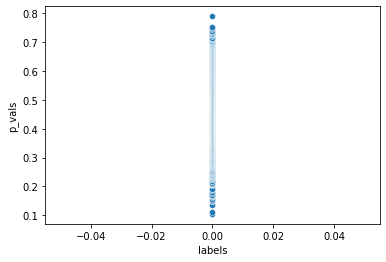

In [25]:
sns.scatterplot(data=sorted_p_vals, x = "labels", y="p_vals")